# Import required libraries
* <b>OpenCV (cv2)</b> to calculate the homography matrix
* <b>social_distancing</b> to calculate distances, detect crowds, etc
* <b>Others</b> for various other tasks

In [1]:
from ctypes import *
import math
import random
import os
import cv2
import numpy as np
import time
import darknet
from social_distancing import SocialDistancing
from matplotlib import pyplot as plt

## Calculate Homography Matrix for camera image transformation
Distances on images do not always represent the real world distance. In this example we can see that the distance between people in the front (356 pixels) is highly overestimated and maps to a real distance of only 149 pixels.<br>
The opposite is the case if we look at people in the back where a distance of 62 pixels maps to a real distance of 83 pixels.<br>

To obtain real distances you have to transform your image - e.g. by a homography matrix.<br>
In order to verify that the transformation worked, I've drawn a rectangle on the image including 4 points that will be mapped to a transformed image. (Look at the tiles)<br>
If everything works well, the transformed image should show a real rectangle.<br>

This transformation matrix will be integrated into our scoring process.

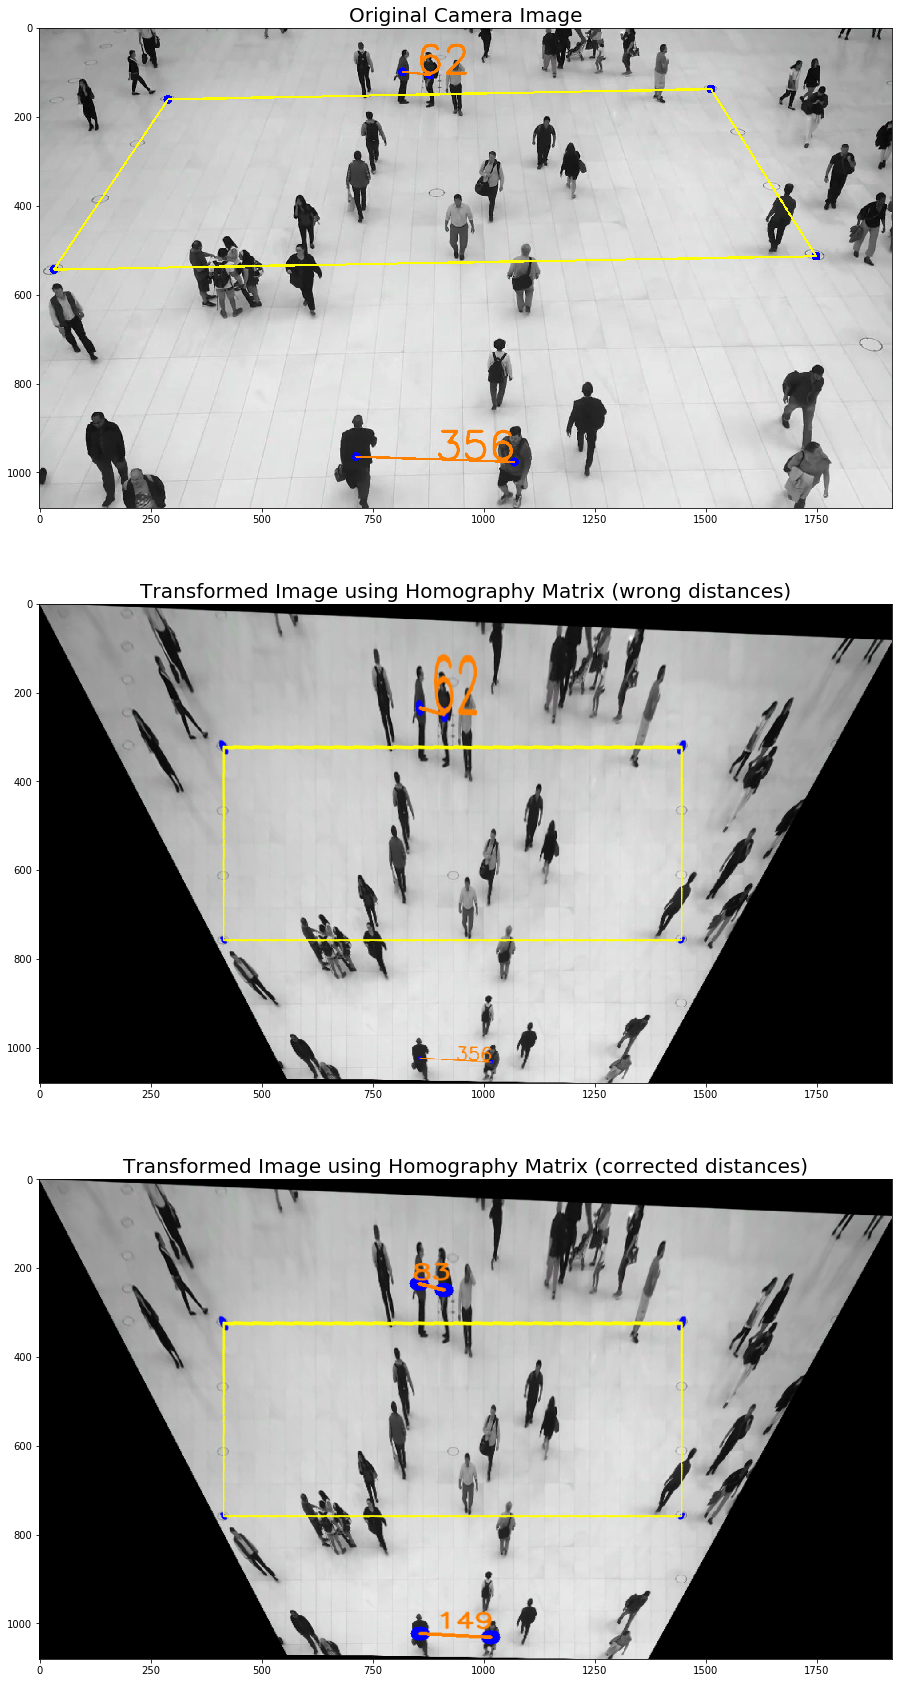

In [2]:
# Load input image an find a minimum of 4 points and their corresponding mappings to your map
img = cv2.imread('misc/100.jpg')
pts_src = np.array([[290, 160], [33, 543], [1749, 513],[1512, 137]]) # points on camera image
pts_dst = np.array([[0, 0], [0, 270], [480, 270],[480, 0]]) # points on map image

# Visualize your points
cv2.circle(img,(290,160), 10, (0,0,255), -1)
cv2.circle(img,(33,543), 10, (0,0,255), -1)
cv2.circle(img,(1749, 513), 10, (0,0,255), -1)
cv2.circle(img,(1512,137), 10, (0,0,255), -1)
cv2.polylines(img, [pts_src.reshape((-1,1,2))],True,(255,255,0),3)

# Example people (show big distance differences)
# Example 1
p1, p2 = (714,964), (1070,976)
cv2.circle(img,p1, 10, (0,0,255), -1)
cv2.circle(img,p2, 10, (0,0,255), -1)
cv2.line(img,p1,p2,(255,128,0),4)
dst = int(np.sqrt( ((p1[0]-p2[0])**2)+((p1[1]-p2[1])**2) ))
text_pt_x = int((p1[0]+p2[0]) / 2)
text_pt_y = int((p1[1]+p2[1]) / 2)
cv2.putText(img, str(dst), (text_pt_x,text_pt_y), cv2.FONT_HERSHEY_SIMPLEX, 3, (255,128,0), 5, cv2.LINE_AA)
# Example 2
p3, p4 = (818,98), (880,105)
cv2.circle(img,p3, 10, (0,0,255), -1)
cv2.circle(img,p4, 10, (0,0,255), -1)
cv2.line(img,p3,p4,(255,128,0),4)
dst = int(np.sqrt( ((p3[0]-p4[0])**2)+((p3[1]-p4[1])**2) ))
text_pt_x = int((p3[0]+p4[0]) / 2)
text_pt_y = int((p3[1]+p4[1]) / 2)
cv2.putText(img, str(dst), (text_pt_x,text_pt_y), cv2.FONT_HERSHEY_SIMPLEX, 3, (255,128,0), 5, cv2.LINE_AA)

# Calculate Homography matrix and apply to camera image (This is the important part for ESP!)
h, status = cv2.findHomography(pts_src, pts_dst)
P = np.array([[0,1920,1920,0],[0,0,1080,1080],[1,1,1,1]])
h_ = h.dot(P)
min_x, min_y = np.min(h_[0] / h_[2]), np.min(h_[1]/h_[2])
trans_mat = np.array([[1,0,-min_x], [0,1,-min_y],[0,0,1]])
F = trans_mat.dot(h)
h__ = F.dot(P)
max_x, max_y = int(np.max(h__[0] / h__[2])), int(np.max(h__[1] / h__[2]))
im_out = cv2.warpPerspective(img, F, (max_x, max_y))

# Visualize corrected distance on transformed image
im_out2 = cv2.imread('misc/100.jpg')
cv2.circle(im_out2,(290,160), 10, (0,0,255), -1)
cv2.circle(im_out2,(33,543), 10, (0,0,255), -1)
cv2.circle(im_out2,(1749, 513), 10, (0,0,255), -1)
cv2.circle(im_out2,(1512,137), 10, (0,0,255), -1)
cv2.polylines(im_out2, [pts_src.reshape((-1,1,2))],True,(255,255,0),3)
im_out2 = cv2.warpPerspective(im_out2, F, (max_x, max_y))
def toworld(xy):
    imagepoint = [xy[0], xy[1], 1]
    worldpoint = np.array(np.dot(np.array(F),imagepoint))
    scalar = worldpoint[2]
    xworld = int(worldpoint[0]/scalar)
    yworld = int(worldpoint[1]/scalar)
    return xworld, yworld
p1_real, p2_real = toworld(p1), toworld(p2)
p3_real, p4_real = toworld(p3), toworld(p4)
dst = int(np.sqrt( ((p1_real[0]*(max_x/1920)-p2_real[0]*(max_y/1080))**2)+((p1_real[1]*(max_x/1920)-p2_real[1]*(max_y/1080))**2) ))
text_pt_x = int((p1_real[0]+p2_real[0]) / 2)
text_pt_y = int((p1_real[1]+p2_real[1]) / 2)
cv2.circle(im_out2,p1_real, 10, (0,0,255), -1)
cv2.circle(im_out2,p2_real, 10, (0,0,255), -1)
cv2.line(im_out2,p1_real,p2_real,(255,128,0),4)
cv2.putText(im_out2, str(dst), (text_pt_x-20,text_pt_y-10), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,128,0), 2, cv2.LINE_AA)
dst = int(np.sqrt( ((p3_real[0]*(max_x/1920)-p4_real[0]*(max_y/1080))**2)+((p3_real[1]*(max_x/1920)-p4_real[1]*(max_y/1080))**2) ))
text_pt_x = int((p3_real[0]+p4_real[0]) / 2)
text_pt_y = int((p3_real[1]+p4_real[1]) / 2)
cv2.circle(im_out2,p3_real, 10, (0,0,255), -1)
cv2.circle(im_out2,p4_real, 10, (0,0,255), -1)
cv2.line(im_out2,p3_real,p4_real,(255,128,0),4)
cv2.putText(im_out2, str(dst), (text_pt_x-20,text_pt_y-10), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,128,0), 2, cv2.LINE_AA)

# Visualization of camera image and transformed image
fig,axes = plt.subplots(nrows = 3, ncols = 1, figsize=(30,30))
axes[0].set_title('Original Camera Image', fontsize=20)
axes[0].imshow(img)
axes[1].set_title('Transformed Image using Homography Matrix (wrong distances)', fontsize=20)
axes[1].imshow(cv2.resize(im_out, (1920,1080)))
axes[2].set_title('Transformed Image using Homography Matrix (corrected distances)', fontsize=20)
axes[2].imshow(cv2.resize(im_out2, (1920,1080)))

## Create our Social Distancing class
The class does the following:
1. Transform coordinates of detected people via homography matrix
2. Calculate distances between people
3. Detect crowds
4. Visualize the results on the image and via a 2D top-view map

In [3]:
social_distancing = SocialDistancing(image_shape=(1080,1920,3), map_view=True, homography_matrix=F, max_distance_detection=80, max_distance_detection_crowd=40, min_crowd_size=3)

## Create the YOLOv4 model and score the images - call social_distancing functions for every frame

In [4]:
netMain = None
metaMain = None
altNames = None

def YOLO_SocialDistancing():
    global metaMain, netMain, altNames
    configPath = "/opt/darknet/cfg/yolov4.cfg"
    weightPath = "/opt/darknet/yolov4.weights"
    metaPath = "/opt/darknet/cfg/coco.data"
    if not os.path.exists(configPath):
        raise ValueError("Invalid config path `" +
                         os.path.abspath(configPath)+"`")
    if not os.path.exists(weightPath):
        raise ValueError("Invalid weight path `" +
                         os.path.abspath(weightPath)+"`")
    if not os.path.exists(metaPath):
        raise ValueError("Invalid data file path `" +
                         os.path.abspath(metaPath)+"`")
    if netMain is None:
        netMain = darknet.load_net_custom(configPath.encode(
            "ascii"), weightPath.encode("ascii"), 0, 1)  # batch size = 1
    if metaMain is None:
        metaMain = darknet.load_meta(metaPath.encode("ascii"))
    if altNames is None:
        try:
            with open(metaPath) as metaFH:
                metaContents = metaFH.read()
                import re
                match = re.search("names *= *(.*)$", metaContents,
                                  re.IGNORECASE | re.MULTILINE)
                if match:
                    result = match.group(1)
                else:
                    result = None
                try:
                    if os.path.exists(result):
                        with open(result) as namesFH:
                            namesList = namesFH.read().strip().split("\n")
                            altNames = [x.strip() for x in namesList]
                except TypeError:
                    pass
        except Exception:
            pass
    # Link to your video
    cap = cv2.VideoCapture("/data/notebooks/shopping_mall.mkv")
    print("Starting the YOLO loop...")

    # Create an image we reuse for each detect
    darknet_image = darknet.make_image(darknet.network_width(netMain),
                                    darknet.network_height(netMain),3)
    while True:
        ret, frame_read = cap.read()
        frame_rgb = cv2.cvtColor(frame_read, cv2.COLOR_BGR2RGB)
        frame_resized = cv2.resize(frame_rgb,
                                   (darknet.network_width(netMain),
                                    darknet.network_height(netMain)),
                                   interpolation=cv2.INTER_LINEAR)

        darknet.copy_image_from_bytes(darknet_image,frame_resized.tobytes())

        detections = darknet.detect_image(netMain, metaMain, darknet_image, thresh=0.25)
        # calls social distancing functions
        image = social_distancing.func_social_distancing(frame_rgb, detections)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        cv2.imshow('Demo', image)
        cv2.waitKey(1)
    cap.release()

In [ ]:
YOLO_SocialDistancing()

Starting the YOLO loop...
